# Coursera Capstone Project

## Week 3 Assignment

For this assignment, you will be required to explore and cluster the neighborhoods in Toronto.

## Assignment Questions:

### Question 1

1. Start by creating a new Notebook for this assignment.

2. Use the Notebook to build the code to scrape the following Wikipedia page, https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M, in order to obtain the data that is in the table of postal codes and to transform the data into a pandas dataframe.

3. To create the dataframe:

 - The dataframe will consist of three columns: PostalCode, Borough, and Neighborhood
 - Only process the cells that have an assigned borough. Ignore cells with a borough that is __Not assigned__.
 - More than one neighborhood can exist in one postal code area. For example, in the table on the Wikipedia page, you will notice that __M5A__ is listed twice and has two neighborhoods: __Harbourfront__ and __Regent Park__. These two rows will be combined into one row with the neighborhoods separated with a comma as shown in row 11 in the above table.
 - If a cell has a borough but a __Not assigned__ neighborhood, then the neighborhood will be the same as the borough.
 - Clean your Notebook and add Markdown cells to explain your work and any assumptions you are making.
 - In the last cell of your notebook, use the __.shape__ method to print the number of rows of your dataframe.


4. Submit a link to your Notebook on your Github repository. (10 marks)

    __Note__: There are different website scraping libraries and packages in Python. For scraping the above table, you can simply use pandas to read the table into a pandas dataframe.

    Another way, which would help to learn for more complicated cases of web scraping is using the BeautifulSoup package. Here is the package's main documentation page: http://beautiful-soup-4.readthedocs.io/en/latest/

    The package is so popular that there is a plethora of tutorials and examples on how to use it. Here is a very good Youtube video on how to use the BeautifulSoup package: https://www.youtube.com/watch?v=ng2o98k983k

    Use pandas, or the BeautifulSoup package, or any other way you are comfortable with to transform the data in the table on the Wikipedia page into the above pandas dataframe.

#### Import necessary Libraries

In [1]:
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner

import requests   # library to handle requests
from bs4 import BeautifulSoup  # library for pulling data out of HTML and XML files
import lxml  # parse the website in lxml format

#### Scraping the table (Approach 1: use pandas)

In [2]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
df = pd.read_html(url)[0]
df

,Postal code,Borough,Neighborhood
0,M1A,Not assigned,NaN
1,M2A,Not assigned,NaN
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Regent Park / Harbourfront
...,...,...,...
175,M5Z,Not assigned,NaN
176,M6Z,Not assigned,NaN
177,M7Z,Not assigned,NaN
178,M8Z,Etobicoke,Mimico NW / The Queensway West / South of Bloo...


#### Scraping the table (Approach 2: use BeautifulSoup package)

In [3]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"

# Define a function to get the page info. from url
def get_page(url):
    response = requests.get(url)
    response.encoding = 'utf-8' 
    soup = BeautifulSoup(response.text, 'lxml')
    return soup

soup = get_page(url)
match = soup.find('table', class_ = "wikitable sortable")

# define the dataframe columns
column_names = ['Postalcode','Borough','Neighborhood']

# instantiate the dataframe
df = pd.DataFrame(columns = column_names)

# Search all the postcode, borough, neighborhood 
for tr_cell in match.find_all('tr'):
    row_data=[]
    for td_cell in tr_cell.find_all('td'):
        row_data.append(td_cell.text.strip())
    if len(row_data)==3:
        df.loc[len(df)] = row_data
df

,Postalcode,Borough,Neighborhood
0,M1A,Not assigned,
1,M2A,Not assigned,
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Regent Park / Harbourfront
...,...,...,...
175,M5Z,Not assigned,
176,M6Z,Not assigned,
177,M7Z,Not assigned,
178,M8Z,Etobicoke,Mimico NW / The Queensway West / South of Bloo...


In [5]:
# Dropping the rows where Borough is 'Not assigned'
df = df[df['Borough']!='Not assigned']

# Replacing the name of the neighbourhoods which are 'Not assigned' with names of Borough
df['Neighborhood'] = df['Neighborhood'].replace('Not assigned', df['Borough'])

# Combining the neighbourhoods with same Postalcode
df = df.groupby(['Postalcode','Borough']).agg(lambda x: ','.join(x))
df.reset_index(inplace=True)

# Replace "/" with ","
df['Neighborhood'] = df['Neighborhood'].replace(to_replace= r'/', value = ',', regex=True)

df

,Postalcode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern , Rouge"
1,M1C,Scarborough,"Rouge Hill , Port Union , Highland Creek"
2,M1E,Scarborough,"Guildwood , Morningside , West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
...,...,...,...
98,M9N,York,Weston
99,M9P,Etobicoke,Westmount
100,M9R,Etobicoke,"Kingsview Village , St. Phillips , Martin Grov..."
101,M9V,Etobicoke,"South Steeles , Silverstone , Humbergate , Jam..."


#### Data preprocessing and cleaning

In [6]:
df.shape

(103, 3)

---

### Question 2

Now that you have built a dataframe of the postal code of each neighborhood along with the borough name and neighborhood name, in order to utilize the Foursquare location data, we need to get the latitude and the longitude coordinates of each neighborhood.

In an older version of this course, we were leveraging the Google Maps Geocoding API to get the latitude and the longitude coordinates of each neighborhood. However, recently Google started charging for their API: http://geoawesomeness.com/developers-up-in-arms-over-google-maps-api-insane-price-hike/, so we will use the Geocoder Python package instead: https://geocoder.readthedocs.io/index.html.

The problem with this Package is you have to be persistent sometimes in order to get the geographical coordinates of a given postal code. So you can make a call to get the latitude and longitude coordinates of a given postal code and the result would be None, and then make the call again and you would get the coordinates. So, in order to make sure that you get the coordinates for all of our neighborhoods, you can run a while loop for each postal code. Taking postal code M5G as an example, your code would look something like this:

```Python
import geocoder # import geocoder

# initialize your variable to None
lat_lng_coords = None

# loop until you get the coordinates
while(lat_lng_coords is None):
  g = geocoder.google('{}, Toronto, Ontario'.format(postal_code))
  lat_lng_coords = g.latlng

latitude = lat_lng_coords[0]
longitude = lat_lng_coords[1]
```

Given that this package can be very unreliable, in case you are not able to get the geographical coordinates of the neighborhoods using the Geocoder package, here is a link to a csv file that has the geographical coordinates of each postal code: http://cocl.us/Geospatial_data

Use the Geocoder package or the csv file to create the dataframe.


Important Note: There is a limit on how many times you can call geocoder.google function. It is 2500 times per day. This should be way more than enough for you to get acquainted with the package and to use it to get the geographical coordinates of the neighborhoods in the Toronto.

Once you are able to create the above dataframe, submit a link to the new Notebook on your Github repository. (2 marks)

In [7]:
# Read csv file
geo_df=pd.read_csv('http://cocl.us/Geospatial_data')
geo_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [8]:
# Rename columns and merge two dataframes together to get the latitude and longitude values 
geo_df.rename(columns={'Postal Code':'Postalcode'},inplace=True)
geo_merged = pd.merge( df, geo_df, on='Postalcode',)
geo_merged

,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern , Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill , Port Union , Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood , Morningside , West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
...,...,...,...,...,...
98,M9N,York,Weston,43.706876,-79.518188
99,M9P,Etobicoke,Westmount,43.696319,-79.532242
100,M9R,Etobicoke,"Kingsview Village , St. Phillips , Martin Grov...",43.688905,-79.554724
101,M9V,Etobicoke,"South Steeles , Silverstone , Humbergate , Jam...",43.739416,-79.588437


---

### Question 3 

Explore and cluster the neighborhoods in Toronto. You can decide to work with only boroughs that contain the word Toronto and then replicate the same analysis we did to the New York City data. It is up to you.

Just make sure:

- to add enough Markdown cells to explain what you decided to do and to report any observations you make.
- to generate maps to visualize your neighborhoods and how they cluster together.
Once you are happy with your analysis, submit a link to the new Notebook on your Github repository. (3 marks)



#### Import necessary Libraries

In [9]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans # import k-means from clustering stage
import folium # map rendering library

####  Slice the original dataframe and create a new dataframe of the Toronto data.

In [10]:
# Getting all the rows from the data frame which contains Toronto in their Borough.
df_toronto = geo_merged[geo_merged['Borough'].str.contains("Toronto")]
df_toronto.reset_index(inplace=True)
df_toronto.head()

,index,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,37,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,41,M4K,East Toronto,"The Danforth West , Riverdale",43.679557,-79.352188
2,42,M4L,East Toronto,"India Bazaar , The Beaches West",43.668999,-79.315572
3,43,M4M,East Toronto,Studio District,43.659526,-79.340923
4,44,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


In [11]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(df_toronto['Borough'].unique()),
        df_toronto.shape[0]
    )
)

The dataframe has 4 boroughs and 39 neighborhoods.


#### Geograpical coordinate of Toronto

In [12]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="Toronto")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


#### Create a map of Toronto with neighborhoods superimposed on top.

In [13]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_toronto['Latitude'], df_toronto['Longitude'], df_toronto['Borough'], df_toronto['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

#### Define Foursquare Credentials and Version

In [ ]:
CLIENT_ID = '*****************************************' # your Foursquare ID
CLIENT_SECRET = '*************************************' # your Foursquare Secret
VERSION = '*******' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

#### Get the top 100 venues within a radius of 500 meters.

In [15]:
# defining radius and limit of venues to get
radius=500
LIMIT=100

#### Create a function to explore all the neighborhoods in Toronto

In [16]:
def getNearbyVenues(names, latitudes, longitudes):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Run the above function on each neighborhood and create a new dataframe called toronto_venues.

In [17]:
toronto_venues = getNearbyVenues(names=df_toronto['Neighborhood'],
                                   latitudes=df_toronto['Latitude'],
                                   longitudes=df_toronto['Longitude']
                                  )

The Beaches
The Danforth West , Riverdale
India Bazaar , The Beaches West
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park , Summerhill East
Summerhill West , Rathnelly , South Hill , Forest Hill SE , Deer Park
Rosedale
St. James Town , Cabbagetown
Church and Wellesley
Regent Park , Harbourfront
Garden District , Ryerson
St. James Town
Berczy Park
Central Bay Street
Richmond , Adelaide , King
Harbourfront East , Union Station , Toronto Islands
Toronto Dominion Centre , Design Exchange
Commerce Court , Victoria Hotel
Roselawn
Forest Hill North & West
The Annex , North Midtown , Yorkville
University of Toronto , Harbord
Kensington Market , Chinatown , Grange Park
CN Tower , King and Spadina , Railway Lands , Harbourfront West , Bathurst Quay , South Niagara , Island airport
Stn A PO Boxes
First Canadian Place , Underground city
Christie
Dufferin , Dovercourt Village
Little Portugal , Trinity
Brockton , Parkdale Village , Exhibition Place
High Park ,

#### Check the size of the resulting dataframe

In [18]:
print(toronto_venues.shape)
toronto_venues.head()

(1623, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,The Beaches,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
2,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
3,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood
4,"The Danforth West , Riverdale",43.679557,-79.352188,MenEssentials,43.677820,-79.351265,Cosmetics Shop


In [19]:
# Check how many venues were returned for each neighborhood
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,57,57,57,57,57,57
"Brockton , Parkdale Village , Exhibition Place",23,23,23,23,23,23
Business reply mail Processing Centre,18,18,18,18,18,18
"CN Tower , King and Spadina , Railway Lands , Harbourfront West , Bathurst Quay , South Niagara , Island airport",17,17,17,17,17,17
Central Bay Street,63,63,63,63,63,63
Christie,17,17,17,17,17,17
Church and Wellesley,78,78,78,78,78,78
"Commerce Court , Victoria Hotel",100,100,100,100,100,100
Davisville,36,36,36,36,36,36


In [20]:
# Check how many unique categories can be curated from all the returned venues
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 231 uniques categories.


#### Analyze Each Neighborhood

In [21]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

print(toronto_onehot.shape)
toronto_onehot.head()

(1623, 231)


,Yoga Studio,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
# Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()

#Comfirm the new size
print(toronto_grouped.shape)
toronto_grouped.head()

(39, 231)


,Neighborhood,Yoga Studio,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store
0,Berczy Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.017544,0.0,0.0,0.0,0.0,0.0
1,"Brockton , Parkdale Village , Exhibition Place",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,Business reply mail Processing Centre,0.055556,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,"CN Tower , King and Spadina , Railway Lands , ...",0.000000,0.058824,0.058824,0.058824,0.117647,0.176471,0.117647,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,Central Bay Street,0.015873,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.015873,0.0,0.0,0.0,0.0,0.0


In [23]:
# print each neighborhood along with the top 5 most common venues
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berczy Park----
                venue  freq
0         Coffee Shop  0.07
1        Cocktail Bar  0.05
2                Café  0.04
3          Restaurant  0.04
4  Seafood Restaurant  0.04


----Brockton , Parkdale Village , Exhibition Place----
            venue  freq
0            Café  0.13
1  Breakfast Spot  0.09
2       Nightclub  0.09
3     Coffee Shop  0.09
4   Grocery Store  0.04


----Business reply mail Processing Centre----
              venue  freq
0       Yoga Studio  0.06
1     Auto Workshop  0.06
2       Pizza Place  0.06
3        Comic Shop  0.06
4  Recording Studio  0.06


----CN Tower , King and Spadina , Railway Lands , Harbourfront West , Bathurst Quay , South Niagara , Island airport----
              venue  freq
0   Airport Service  0.18
1    Airport Lounge  0.12
2  Airport Terminal  0.12
3          Boutique  0.06
4  Sculpture Garden  0.06


----Central Bay Street----
                venue  freq
0         Coffee Shop  0.17
1  Italian Restaurant  0.08
2              

In [24]:
# Define a function to sort the venues in descending order.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [25]:
# Create the new dataframe and display the top 10 venues for each neighborhood.
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Beer Bar,Cheese Shop,Restaurant,Café,Bakery,Seafood Restaurant,Bistro,Jazz Club
1,"Brockton , Parkdale Village , Exhibition Place",Café,Coffee Shop,Nightclub,Breakfast Spot,Pet Store,Stadium,Intersection,Bakery,Italian Restaurant,Restaurant
2,Business reply mail Processing Centre,Yoga Studio,Auto Workshop,Park,Comic Shop,Pizza Place,Recording Studio,Burrito Place,Restaurant,Brewery,Light Rail Station
3,"CN Tower , King and Spadina , Railway Lands , ...",Airport Service,Airport Lounge,Airport Terminal,Sculpture Garden,Boutique,Rental Car Location,Plane,Boat or Ferry,Harbor / Marina,Bar
4,Central Bay Street,Coffee Shop,Café,Italian Restaurant,Sandwich Place,Ice Cream Shop,Middle Eastern Restaurant,Bar,Thai Restaurant,Burger Joint,Fried Chicken Joint


Find best K

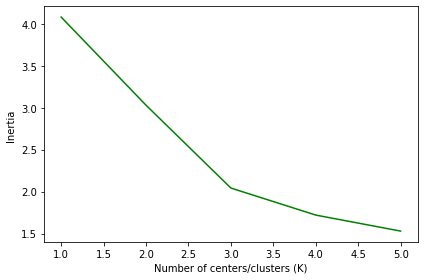

In [26]:
Ks = 6 # number of ks we will test
inertias = np.zeros((Ks-1))

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

for n in range(1,Ks):
    
    # run k-means clustering
    kmeans = KMeans(n_clusters=n, random_state=0).fit(toronto_grouped_clustering)
    inertias[n-1] = kmeans.inertia_

# display the inertia    
inertias

import matplotlib.pyplot as plt

# Plot the inertia with the different k to find the better balance
plt.plot(range(1,Ks),inertias,'g')
plt.ylabel('Inertia ')
plt.xlabel('Number of centers/clusters (K)')
plt.tight_layout()
plt.show()

Run k-means to cluster the neighborhood into 5 clusters.

In [27]:
# Set number of clusters
kclusters = 3

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:20] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [28]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

df_toronto_merged = df_toronto

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
df_toronto_merged = df_toronto.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

df_toronto_merged = df_toronto_merged.drop(['index'],axis=1)

df_toronto_merged.head()

,Postalcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,Trail,Health Food Store,Pub,Women's Store,Dance Studio,Electronics Store,Eastern European Restaurant,Donut Shop,Doner Restaurant,Dog Run
1,M4K,East Toronto,"The Danforth West , Riverdale",43.679557,-79.352188,0,Greek Restaurant,Coffee Shop,Italian Restaurant,Ice Cream Shop,Furniture / Home Store,Frozen Yogurt Shop,Bookstore,Bubble Tea Shop,Bakery,Pub
2,M4L,East Toronto,"India Bazaar , The Beaches West",43.668999,-79.315572,0,Sandwich Place,Fast Food Restaurant,Movie Theater,Pub,Steakhouse,Sushi Restaurant,Food & Drink Shop,Italian Restaurant,Burrito Place,Ice Cream Shop
3,M4M,East Toronto,Studio District,43.659526,-79.340923,0,Café,Coffee Shop,Gastropub,Bakery,Brewery,American Restaurant,Sandwich Place,Cheese Shop,Pizza Place,Clothing Store
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,0,Swim School,Park,Construction & Landscaping,Bus Line,Women's Store,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Donut Shop,Doner Restaurant


Finally, let's visualize the resulting clusters

In [29]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.prism(np.linspace(0, 1, len(ys)))
prism = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_toronto_merged['Latitude'], df_toronto_merged['Longitude'], df_toronto_merged['Neighborhood'], df_toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=prism[cluster-1],
        fill=True,
        fill_color=prism[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

####  Examine Clusters

In [30]:
# Cluster 1
df_toronto_merged.loc[df_toronto_merged['Cluster Labels'] == 0, df_toronto_merged.columns[[1] + list(range(5, df_toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,East Toronto,0,Trail,Health Food Store,Pub,Women's Store,Dance Studio,Electronics Store,Eastern European Restaurant,Donut Shop,Doner Restaurant,Dog Run
1,East Toronto,0,Greek Restaurant,Coffee Shop,Italian Restaurant,Ice Cream Shop,Furniture / Home Store,Frozen Yogurt Shop,Bookstore,Bubble Tea Shop,Bakery,Pub
2,East Toronto,0,Sandwich Place,Fast Food Restaurant,Movie Theater,Pub,Steakhouse,Sushi Restaurant,Food & Drink Shop,Italian Restaurant,Burrito Place,Ice Cream Shop
3,East Toronto,0,Café,Coffee Shop,Gastropub,Bakery,Brewery,American Restaurant,Sandwich Place,Cheese Shop,Pizza Place,Clothing Store
4,Central Toronto,0,Swim School,Park,Construction & Landscaping,Bus Line,Women's Store,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Donut Shop,Doner Restaurant
5,Central Toronto,0,Park,Department Store,Gym,Breakfast Spot,Sandwich Place,Dog Run,Food & Drink Shop,Hotel,Electronics Store,Eastern European Restaurant
6,Central Toronto,0,Coffee Shop,Clothing Store,Park,Salon / Barbershop,Restaurant,Rental Car Location,Café,Chinese Restaurant,Mexican Restaurant,Sporting Goods Shop
7,Central Toronto,0,Dessert Shop,Sandwich Place,Pizza Place,Coffee Shop,Gym,Sushi Restaurant,Italian Restaurant,Café,Brewery,Restaurant
9,Central Toronto,0,Pub,Coffee Shop,Supermarket,Pizza Place,Bank,Sushi Restaurant,Fried Chicken Joint,Health & Beauty Service,Bagel Shop,Sports Bar
11,Downtown Toronto,0,Coffee Shop,Pub,Café,Bakery,Restaurant,Park,Italian Restaurant,Pizza Place,Playground,Pharmacy


In [31]:
# Cluster 2
df_toronto_merged.loc[df_toronto_merged['Cluster Labels'] == 1, df_toronto_merged.columns[[1] + list(range(5, df_toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Central Toronto,1,Park,Women's Store,Deli / Bodega,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Donut Shop,Doner Restaurant,Dog Run,Distribution Center
10,Downtown Toronto,1,Park,Playground,Trail,Women's Store,Dance Studio,Electronics Store,Eastern European Restaurant,Donut Shop,Doner Restaurant,Dog Run


In [32]:
# Cluster 3
df_toronto_merged.loc[df_toronto_merged['Cluster Labels'] == 2, df_toronto_merged.columns[[1] + list(range(5, df_toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,Central Toronto,2,Garden,Women's Store,Deli / Bodega,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Donut Shop,Doner Restaurant,Dog Run


After examining each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories we can create a profile for each group, considering the common characteristics of each cluster:

__Cluster 1__: Cafe, Restaurant and Hotel Venues

__Cluster 2__: Park and Hiking Venues

__Cluster 3__: Multiple Social Venues